In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib as plt

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In the first part of this week's work, I'm going to apply the pre-trained model described in the [Lample et al](https://arxiv.org/abs/1603.01360) paper. We've been referring to this as a "Glample" model, so I'll stick with that. In this work, they use a bi-directional LSTM with a conditional random field on top to output the classes. Performance is roughly on par with other systems, but provides the advantage of being language agnostic and does not rely on any external labeled data (e.g. gazetteer). Performance on Spanish and German surpasses previous state-of-the-art.

To evaluate the glample model, I need to write an output file

In [3]:
import lxml.etree as etree
from bs4 import BeautifulSoup
import glob
files = glob.glob('data/audible/processedText/*.xml')
outdat = open('audible_files.txt', 'w')
for f in files:
    xml_data = open(f).read()
    soup = BeautifulSoup(xml_data, 'lxml')
    sentences = soup.find_all('s')
    for s in sentences:
        tokens = s.find_all(['w', 'c'])
        for i in tokens:
            outdat.write(i.text.encode('utf8'))
            outdat.write(' ')
        outdat.write('\n')

outdat.close()

Having written this file, I ran it through glample via the command-line utility function. It returned an output file in which the words were tagged as below:

In [4]:
import codecs

f = codecs.open('tagger-master/output.txt', 'r', 'utf-8')
glampledat = f.readlines()
glampledat[0:10]

[u'"__O There__O was__O no__O water__O in__O the__O cat__O \'s__O bowl__O ,__O "__O she__O said__O .__O\n',
 u'"__O He__O drinks__O out__O of__O the__O toilet__O ,__O "__O I__O said__O .__O\n',
 u'"__O That__O \'s__O disgusting__O .__O "__O\n',
 u'"__O That__O \'s__O what__O I__O \'ve__O been__O telling__O him__O ,__O "__O I__O said__O .__O\n',
 u'But__O she__O saw__O no__O humor__O in__O my__O remark__O .__O\n',
 u'She__O served__O oatmeal__O in__O two__O bowls__O and__O placed__O them__O on__O the__O breakfast__O table__O ,__O then__O began__O hunting__O for__O spoons__O and__O coffee__O cups__O .__O\n',
 u'I__O looked__O at__O my__O watch__O .__O\n',
 u'"__O I__O \'m__O running__O a__O little__O bit__O late__O for__O Mass__B-ORG ,__O "__O I__O lied__O .__O\n',
 u'"__O Where__O \'s__O your__O butter__O dish__O ?__O "__O\n',
 u'"__O I__O do__O n\'t__O have__O one__O .__O\n']

As in some of the previous efforts, the tokenizers worked a bit differently. So below we take care to line things up.

In [5]:
glampletags = []
for i, sentence in enumerate(glampledat):
    glampletags.append((sentence.split()))

In [6]:
glample_text = []# containers to hold data
glample_tag = []
audible_text = []
audible_tag = []
file_num = []
corpus_counter = -1 #glample file is just one - audible is many. this keeps track of which sentence across files
for k, f in enumerate(files):
    xml_data = open(f).read()
    soup = BeautifulSoup(xml_data, 'lxml')
    sentences = soup.find_all('s')
    for j, s in enumerate(sentences):
        corpus_counter = corpus_counter + 1
        glample_sent = glampletags[corpus_counter] #pluck out the current sentence
        glample_words = [i.split('__') for i in glample_sent] #split the words from the tags
        words = s.find_all(['w', 'c'])
        if len(glample_words) == len(words): #if the tokenization is the same
            for i, w in enumerate(words):
                if 'ner' in w.attrs:
                    glample_text.append(glample_words[i][0])
                    glample_tag.append(glample_words[i][1])
                    audible_text.append(w.text)
                    audible_tag.append(w.attrs['ner'])
                    file_num.append(k)
                else:
                    glample_text.append(glample_words[i][0])
                    glample_tag.append(glample_words[i][1])
                    audible_text.append(w.text)
                    audible_tag.append('O-')
                    file_num.append(k)
        else: #if the tokenization is not the same
            offset = 0 #keeps track of how far in front of the current tag we're looking
            gl_index = 0 #independent indexer for glample tags
            for i, w in enumerate(words):
                offset = 0
                
                while w.text != glample_words[gl_index][0]: #for the token that doesn't match, start gathering words & tags from in front of it
                    offset += 1
                    glample_words[gl_index][0] = glample_words[gl_index][0] + ' ' + glample_words[gl_index+offset][0]
                    glample_words[gl_index][1] = glample_words[gl_index][1] + ' ' + glample_words[gl_index+offset][1]

                gl_index += offset #put the index up to where the final tag was added
                if 'ner' in w.attrs:
                    glample_text.append(glample_words[gl_index-offset][0])
                    glample_tag.append(glample_words[gl_index-offset][1])
                    audible_text.append(w.text)
                    audible_tag.append(w.attrs['ner'])
                    file_num.append(k)
                    gl_index += 1 #increment index to look at next word
                    
                else:
                    glample_text.append(glample_words[gl_index-offset][0])
                    glample_tag.append(glample_words[gl_index-offset][1])
                    audible_text.append(w.text)
                    audible_tag.append('O-')
                    file_num.append(k)
                    gl_index += 1
            

In [21]:
import pandas as pd
df = pd.DataFrame({'glample_text':glample_text,
             'glample_tag':glample_tag,
             'audible_text':audible_text,
             'audible_tag':audible_tag,
             'filenum':file_num})

# Standardizing tags

Because of the different tagging systems, we need to standardize the tags. I do this below, then show the performance of the glample system.

In [22]:
from audible import clean_audible_tags

df['audible_tag'] = df.audible_tag.map(str) + df.filenum.map(str)

df['aud_clean'] = df.audible_tag.apply(clean_audible_tags)
df['counter'] = df.groupby('audible_tag').cumcount()
df['iob_sys'] = 'O'
df['iob_sys'][df.counter==0] = 'B'
df['iob_sys'][df.counter>0] = 'I'
df['aud_clean'][df.aud_clean!='O-'] = df['iob_sys']+df['aud_clean']
df.aud_clean.value_counts()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


O-     315461
B-P      7858
I-P      1199
B-L      1042
I-L       365
B-O       208
I-O       183
Name: aud_clean, dtype: int64

In [23]:
import re
def clean_glample_tags(tags):
    prog = re.compile('^O')
    if prog.match(tags):
        out = 'O-'
    else:
        out = tags
    prog = re.compile('^(B|I)-(P|L|O)')
    if prog.match(out):
        matched = prog.match(out).group(1)+'-'+prog.match(out).group(2)
        out = matched
    prog = re.compile('^(B|I)-MISC')
    if prog.match(tags):
        out = 'O-'
    return(out)

df['glamp_clean'] = df.glample_tag.apply(clean_glample_tags)
df.glamp_clean.value_counts()

O-     314086
B-P      7724
B-L      1260
I-P      1140
B-O       877
I-O       707
I-L       522
Name: glamp_clean, dtype: int64

For convenience, below I'm gathering the tags from each of the systems.

In [24]:
df_spacy = pd.read_csv('temp', sep=' ', header=None, names = ['token', 'aud', 'spacy'])
df_corenlp = pd.read_csv('temp_stanford', sep=' ', header=None, names = ['token', 'aud', 'stanford'])
df_glample = pd.read_csv('temp_glample', sep=' ', header=None, names = ['token', 'aud', 'glample'])
df['spacy'] = df_spacy['spacy']
df['stanford'] = df_corenlp['stanford']
df = df[['audible_text', 'aud_clean', 'glamp_clean', 'spacy', 'stanford']]
df.head()

,audible_text,aud_clean,glamp_clean,spacy,stanford
0,"""",O-,O-,O-,O-
1,There,O-,O-,O-,O-
2,was,O-,O-,O-,O-
3,no,O-,O-,O-,O-
4,water,O-,O-,O-,O-


In [12]:
outdat = df[['audible_text', 'aud_clean', 'glamp_clean']]
outdat['audible_text'] = outdat.audible_text.apply(lambda x: x.replace(' ', ''))
outdat.to_csv('temp_glample', sep=' ', encoding='utf-8', index=False, header=False)
outdat = df[['audible_text', 'aud_clean', 'spacy']]
outdat['audible_text'] = outdat.audible_text.apply(lambda x: x.replace(' ', ''))
outdat.to_csv('temp_spacy', sep=' ', encoding='utf-8', index=False, header=False)
outdat = df[['audible_text', 'aud_clean', 'stanford']]
outdat['audible_text'] = outdat.audible_text.apply(lambda x: x.replace(' ', ''))
outdat.to_csv('temp_stanford', sep=' ', encoding='utf-8', index=False, header=False)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

`processed 326316 tokens with 9108 phrases; found: 9864 phrases; correct: 7520.`

`accuracy:  97.39%; precision:  76.24%; recall:  82.56%; FB1:  79.27
                L: precision:  61.28%; recall:  74.28%; FB1:  67.16  1263
                O: precision:  12.77%; recall:  53.85%; FB1:  20.65  877
                P: precision:  85.89%; recall:  84.42%; FB1:  85.15  7724`

As seen above, the performance is roughly on par with the coreNLP system (F1 of 83.7). This is about what would be expected based on the glample paper, as they indicated that performance was roughly equivalent with other state of the art systems.

# Error analysis

For this section, I'm going to do some exploration of what kinds of errors are made by each of the systems. First, I'm going to examine those instances where audible's tags disagreed with the other three systems. There are almost 800 instances of this problem.

In [28]:
df['unique_tags'] = df.iloc[:, 1:5].apply(lambda x: x.nunique(), axis=1)
df['unique_tags_noaud'] = df.iloc[:, 2:5].apply(lambda x: x.nunique(), axis=1)
df[(df['unique_tags']>1) & (df['unique_tags_noaud'] == 1)].shape

(788, 7)

In [29]:
auds = df[(df['unique_tags']>1) & (df['unique_tags_noaud'] == 1)]['aud_clean'].value_counts()
totals = df.aud_clean.value_counts()

In [74]:
from __future__ import division
plot_dat = pd.DataFrame({'auds':auds,
             'totals':totals})
plot_dat['ratio'] = plot_dat.auds/plot_dat.totals

# What kind of disagreements are between audible's data and everything else?

The figure below represents a ratio of audible tags that disagree with the other three systems over the total number of tags of each type as indicated by audible's system. Thus, any tag that audible applies to data with greater frequency than the other three systems would be represented here with high values. This metric suggests that Audible is more likely to extend a label into multiple words than the other systems, as the `I-` tags have higher values than the `B-` tags for people and locations, while the rates are closer to equal for organizations. Additionally, it appears that there's generally more disagreement over the organizational tags than anything else. This is consistent with the performance metrics from the other systems, which had low performance for Organizations.

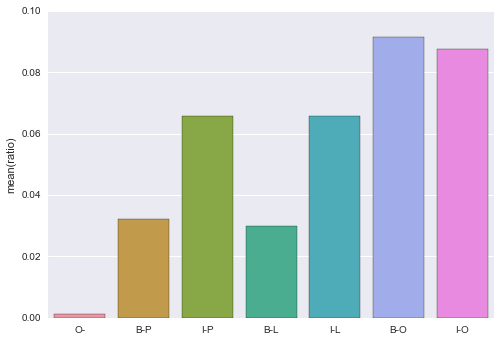

In [31]:
sns.barplot(plot_dat.index, plot_dat.ratio)

Below, I sample twenty instances in which Audible's label disagreed with all the others. For each of these twenty instances, I examine a window of text (instance +/- 5 words) to determine whether it is accurate or not. Of the 20 instances, my examination suggests that Audible's label is wrong **12** times.

In [75]:
import random
locations = df[(df['unique_tags']>1) & (df['unique_tags_noaud'] == 1)].index.tolist()
samples = random.sample(locations, 20)
sample_locations = []
f = codecs.open('examples_audible.txt', 'w', 'utf8')
f.write('word \t audible \t glample \t spacy \t stanford \n')
for i in samples:
    for j in range(i-5, i+5):
        out_line = df.iloc[j, 0:5].tolist()
        for cell in out_line:
            f.write(cell)
            f.write('\t\t')
        f.write('\n')
    f.write('\n\n')
f.close()

# What kind of disagreements are between each of the other systems?

I now perform a similar analysis for each of the other systems

## Glample
We see that glample contains about 1400 instances where it disagrees with all the other systems. The figure below suggests that Glample is overlabeling organizations - when looking at just those cases where its label is inconsistent with all three other systems, the number of organization labels relative to the total number of organization labels applied by glample is relatively high. Additionally, it appears glample has a tendency to extend location tags more than it does other tags. We also see fairly low error rates for people.

In [50]:
df['unique_tags_noglamp'] = df[['aud_clean', 'spacy', 'stanford']].apply(lambda x: x.nunique(), axis=1)
df[(df['unique_tags']>1) & (df['unique_tags_noglamp'] == 1)].shape

(1435, 8)

In [63]:
glamps = df[(df['unique_tags']>1) & (df['unique_tags_noglamp'] == 1)]['glamp_clean'].value_counts()
totals = df.glamp_clean.value_counts()
plot_dat = pd.DataFrame({'glamps':glamps,
             'totals':totals})
plot_dat['ratio'] = plot_dat.glamps/plot_dat.totals

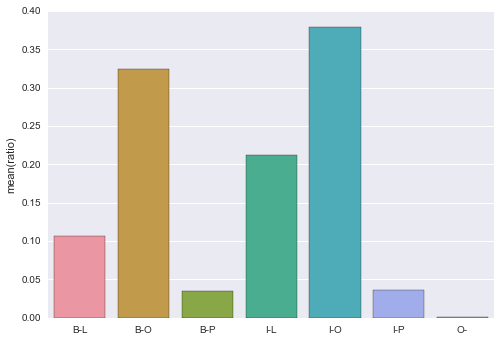

In [64]:
sns.barplot(plot_dat.index, plot_dat.ratio)

In the file written below, it appears that Glample's label is mistaken **14** times

In [65]:
locations = df[(df['unique_tags']>1) & (df['unique_tags_noglamp'] == 1)].index.tolist()
samples = random.sample(locations, 20)
sample_locations = []
f = codecs.open('examples_glample.txt', 'w', 'utf8')
f.write('word \t audible \t glample \t spacy \t stanford \n')
for i in samples:
    for j in range(i-5, i+5):
        out_line = df.iloc[j, 0:5].tolist()
        for cell in out_line:
            f.write(cell)
            f.write('\t\t')
        f.write('\n')
    f.write('\n\n')
f.close()

## Spacy
We see that Spacy contains about 1700 instances where it disagrees with all the other systems. The figure below suggests that Spacy is also overlabeling organizations.  In contrast to the previous systems, however, we see much less of a tendency for longer labeling here. `I-L` and `I-O` tags are both underrepresented in comparison to the `B-L` and `B-O` tags.

In [66]:
df['unique_tags_nospacy'] = df[['aud_clean', 'glamp_clean', 'stanford']].apply(lambda x: x.nunique(), axis=1)
df[(df['unique_tags']>1) & (df['unique_tags_nospacy'] == 1)].shape

(1697, 9)

In [67]:
spac = df[(df['unique_tags']>1) & (df['unique_tags_nospacy'] == 1)]['spacy'].value_counts()
totals = df.spacy.value_counts()
plot_dat = pd.DataFrame({'spacy':spac,
             'totals':totals})
plot_dat['ratio'] = plot_dat.spacy/plot_dat.totals

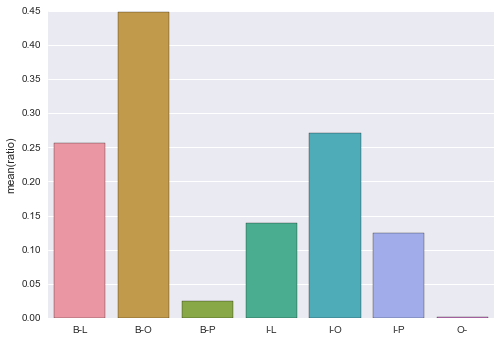

In [68]:
sns.barplot(plot_dat.index, plot_dat.ratio)

In the file below, it appears Spacy's label is mistaken **12** times

In [71]:
locations = df[(df['unique_tags']>1) & (df['unique_tags_nospacy'] == 1)].index.tolist()
samples = random.sample(locations, 20)
sample_locations = []
f = codecs.open('examples_spacy.txt', 'w', 'utf8')
f.write('word \t audible \t glample \t spacy \t stanford \n')
for i in samples:
    for j in range(i-5, i+5):
        out_line = df.iloc[j, 0:5].tolist()
        for cell in out_line:
            f.write(cell)
            f.write('\t\t')
        f.write('\n')
    f.write('\n\n')
f.close()

## Stanford
We see that stanford contains 455 instances where it disagrees with all the other systems. Unlike each of the other systems, I would not say that Stanford is overlabeling organizations. Indeed, it appears that Stanford's errors are more about overlabeling sequences than mistakes in particular types of tags.

In [69]:
df['unique_tags_nostanf'] = df[['aud_clean', 'glamp_clean', 'spacy']].apply(lambda x: x.nunique(), axis=1)
df[(df['unique_tags']>1) & (df['unique_tags_nostanf'] == 1)].shape

(455, 10)

In [70]:
stanf = df[(df['unique_tags']>1) & (df['unique_tags_nostanf'] == 1)]['spacy'].value_counts()
totals = df.spacy.value_counts()
plot_dat = pd.DataFrame({'stanf':stanf,
             'totals':totals})
plot_dat['ratio'] = plot_dat.stanf/plot_dat.totals

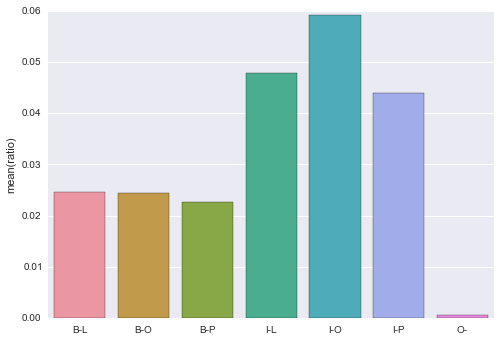

In [72]:
sns.barplot(plot_dat.index, plot_dat.ratio)

In the file below, it appears Stanford's label is mistaken **12** times

In [73]:
locations = df[(df['unique_tags']>1) & (df['unique_tags_nostanf'] == 1)].index.tolist()
samples = random.sample(locations, 20)
sample_locations = []
f = codecs.open('examples_stanf.txt', 'w', 'utf8')
f.write('word \t audible \t glample \t spacy \t stanford \n')
for i in samples:
    for j in range(i-5, i+5):
        out_line = df.iloc[j, 0:5].tolist()
        for cell in out_line:
            f.write(cell)
            f.write('\t\t')
        f.write('\n')
    f.write('\n\n')
f.close()